http://modernstatisticalworkflow.blogspot.ch/2018/02/regime-switching-models-in-stan.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl as quandl
import arviz as az

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
googl = quandl.get("WIKI/GOOGL", collapse = "weekly")

In [3]:
googl = (googl.pipe(lambda x: x.assign(l_ac=np.log(x['Adj. Close'])))
              .pipe(lambda x: x.assign(dl_ac=np.hstack([np.nan, np.diff(x['l_ac'])])))
              .query('index > "2010-01-01"')
         )

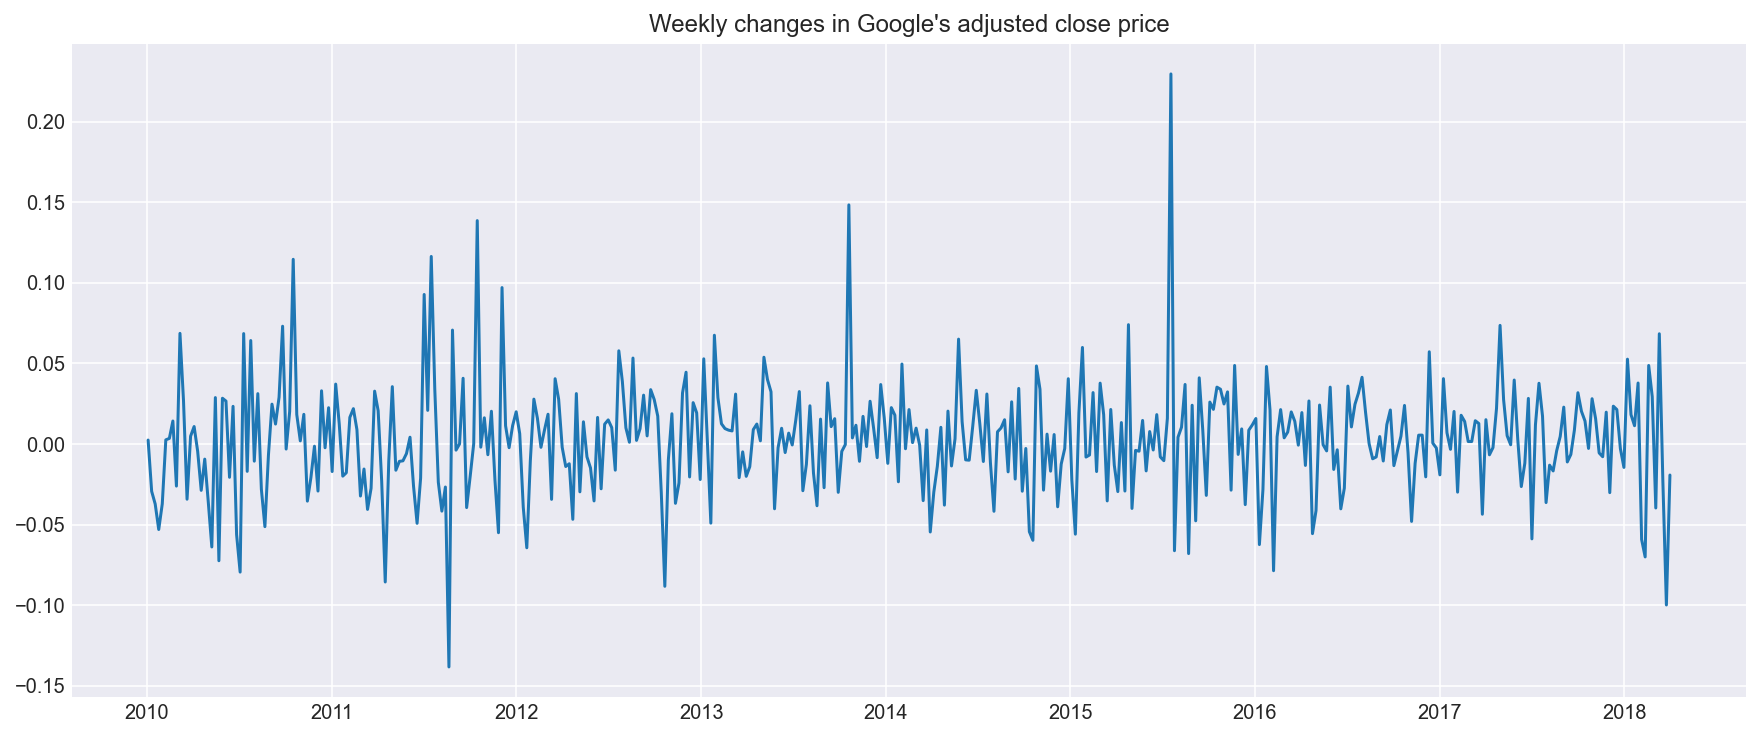

In [4]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(googl['dl_ac'])
ax.set_title("Weekly changes in Google's adjusted close price");

In [5]:
T = googl.shape[0]
y = np.asarray(googl['dl_ac'])*100

Test recurrent function that generates f and xi

In [6]:
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp

from jax.config import config
config.update("jax_enable_x64", True)

tfd = tfp.distributions
tfb = tfp.bijectors

INFO:tensorflow:Using local port 19764
INFO:tensorflow:Using local port 24346
INFO:tensorflow:Using local port 23203
INFO:tensorflow:Using local port 17508
INFO:tensorflow:Using local port 18692
INFO:tensorflow:Using local port 16632
INFO:tensorflow:Using local port 19529
INFO:tensorflow:Using local port 18973
INFO:tensorflow:Using local port 22027
INFO:tensorflow:Using local port 22470


In [7]:
dtype = np.float64  # <== need high numerical precision, otherwise risk of nan in log_prob 

eta0 = np.random.rand(100, 2).astype(dtype)

P = np.asarray([[.75, .25], [.25, .75]], dtype=dtype)
xi_ = jnp.array(.75, dtype=dtype)
xi_out = jnp.array(.75, dtype=dtype)

def ft_xit_dt(ft, xi, Eta, P):
    xit0 = jnp.stack([xi, 1.-xi], axis=-1)[..., None]
    ft = jnp.sum(jnp.matmul(xit0 * P, Eta))
    xi1 = (P[0, 0] * xi + P[1, 0] * (1. - xi)) * Eta[0] / ft
    return (ft, xi1), (ft, xi1)

ft_xit_dt(jnp.array(0., dtype=dtype), xi_out, eta0[0], P)

_, (ft1, xi1) = jax.lax.scan(
    lambda args, eta: ft_xit_dt(*args, eta, P),
    init=(jnp.array(0., dtype=dtype), xi_out),
    xs=eta0)

/opt/miniconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
ft2 = np.zeros(100)
xi2 = np.zeros(100)

ftfunc = lambda eta, xi: P[0, 0]*xi*eta[0] +\
                         P[0, 1]*xi*eta[1] +\
                         P[1, 1]*(1 - xi)*eta[1] +\
                         P[1, 0]*(1 - xi)*eta[0]
Eta = eta0[0]
Xi_ = np.asarray([.75])
ft2[0] = ftfunc(Eta, Xi_)
xi2[0] = (P[0, 0] * Xi_ + P[1, 0] * (1 - Xi_)) * Eta[0] / ft2[0]


for i in range(1, 100):
    Eta = eta0[i]
    Xi_ = xi2[i - 1]
    ft2[i] = ftfunc(Eta, Xi_)
    xi2[i] = (P[0, 0] * Xi_ + P[1, 0] * (1 - Xi_)) * Eta[0] / ft2[i]

In [9]:
np.testing.assert_almost_equal(ft1, ft2)
np.testing.assert_almost_equal(xi1, xi2)

The scan function is fine, to the next step:

Random walk with Markov transition

In [10]:
y_tf = jnp.asarray(y, dtype=dtype)
n_timepoint = y_tf.shape[0]

In [11]:
root = tfd.JointDistributionCoroutine.Root

@tfd.JointDistributionCoroutine
def prior():
    p = yield root(tfd.Sample(
        tfd.Beta(jnp.array(10., dtype=dtype), 2.),
        sample_shape=2))
    alpha = yield root(tfd.Sample(
        tfd.Normal(jnp.array(0., dtype=dtype), .1), 
        sample_shape=2))
    sigma = yield root(tfd.Sample(
        tfd.HalfCauchy(jnp.array(0., dtype=dtype), 1.),
        sample_shape=2))
    y_tm1_init = yield root(tfd.Normal(jnp.array(0., dtype=dtype), .1))
    rho = yield root(tfd.TruncatedNormal(
        loc=jnp.array(1., dtype=dtype), scale=.1, low=0., high=10.))
    xi_init = yield root(tfd.Beta(jnp.array(2., dtype=dtype), 2.))

@jax.vmap
def build_time_series(p, alpha, sigma, y_tm1_init, rho, xi_init):
    P = jnp.array([[p[0], 1-p[0]], [1-p[1], p[1]]])
    eta1 = tfd.Normal(loc=alpha[0], scale=sigma[0]).prob(y_tf)
    eta2_0 = tfd.Normal(
        loc=alpha[1] + rho * y_tm1_init,
        scale=sigma[1]
    ).prob(y_tf[0])
    eta2_1 = tfd.Normal(
        loc=(alpha[1] + rho * y_tf[:-1]),
        scale=sigma[1]
    ).prob(y_tf[1:])
    eta2 = jnp.concatenate([eta2_0[..., None], jnp.squeeze(eta2_1)], axis=0)
    eta = jnp.stack([jnp.squeeze(eta1), eta2], axis=-1)
    
    _, (ft1, xi1) = jax.lax.scan(
        lambda args, eta: ft_xit_dt(*args, eta, P),
        init=(jnp.zeros_like(xi_init), xi_init),
        xs=eta)

    return ft1, xi1

p, alpha, sigma, y_tm1_init, rho, xi_init = prior.sample(5, seed=jax.random.PRNGKey(10))
ft, xi = build_time_series(p, alpha, sigma, y_tm1_init, rho, xi_init)

In [12]:
@jax.vmap
def likelihood_fn(p, alpha, sigma, y_tm1_init, rho, xi_init):
    P = jnp.array([[p[0], 1-p[0]], [1-p[1], p[1]]])
    eta1 = tfd.Normal(loc=alpha[0], scale=sigma[0]).prob(y_tf)
    eta2_0 = tfd.Normal(
        loc=alpha[1] + rho * y_tm1_init,
        scale=sigma[1]
    ).prob(y_tf[0])
    eta2_1 = tfd.Normal(
        loc=(alpha[1] + rho * y_tf[:-1]),
        scale=sigma[1]
    ).prob(y_tf[1:])
    eta2 = jnp.concatenate([eta2_0[..., None], jnp.squeeze(eta2_1)], axis=0)
    eta = jnp.stack([jnp.squeeze(eta1), eta2], axis=-1)

    def ft_xit_dt(ft0, xi, Eta, P):
        xit0 = jnp.stack([xi, 1.-xi], axis=-1)[..., None]
        ft1 = jnp.sum(jnp.matmul(xit0 * P, Eta))
        xi1 = (P[0, 0] * xi + P[1, 0] * (1. - xi)) * Eta[0] / ft1
        return (ft0 + jnp.log(ft1), xi1), (ft, xi1)

    (ft_sum, _), (ft1, xi1) = jax.lax.scan(
        lambda args, eta: ft_xit_dt(*args, eta, P),
        init=(jnp.zeros_like(xi_init), xi_init),
        xs=eta)
    return ft_sum

In [13]:
target_log_prob_fn = lambda *args: prior.log_prob(*args) + likelihood_fn(*args)

init_position = list(prior.sample(25, seed=jax.random.PRNGKey(15)))
init_position[2] = jnp.ones_like(init_position[2]) * jnp.asarray([[3., 10.]], dtype=dtype)
init_position[-2] = jnp.ones_like(init_position[-2])
init_position[-4] = jnp.ones_like(init_position[-4])
np.alltrue(np.isfinite(target_log_prob_fn(*init_position)))

True

In [14]:
jax.jit(target_log_prob_fn)(*prior.sample(25, seed=jax.random.PRNGKey(15)))
jax.jit(likelihood_fn)(*prior.sample(1, seed=jax.random.PRNGKey(15)))

DeviceArray([-1388.09723953], dtype=float64)

In [15]:
#@title Sample with NUTS
unnest = tfp.experimental.unnest

def gen_nuts_sample_fn(target_log_prob_fn, bijector, draws, tune):

  @jax.jit
  def run_inference_nuts(init_state, seed):
    seed, tuning_seed, sample_seed = jax.random.split(seed, 3)
    def gen_kernel(step_size):
      hmc = tfp.mcmc.NoUTurnSampler(
          target_log_prob_fn=target_log_prob_fn, step_size=step_size)
      hmc = tfp.mcmc.TransformedTransitionKernel(
          hmc, bijector=bijector)
      tuning_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
          hmc, tune // 2, target_accept_prob=0.85)
      return tuning_hmc

    def tuning_trace_fn(_, pkr): 
      return (pkr.inner_results.transformed_state,
              pkr.new_step_size)

    def get_tuned_stepsize(samples, step_size):
      return jnp.std(samples, axis=0) * step_size[-1]

    step_size = jax.tree_map(lambda x: jnp.ones_like(x), init_state)
    tuning_hmc = gen_kernel(step_size)
    init_samples, tuning_result = tfp.mcmc.sample_chain(
        num_results=200,
        num_burnin_steps=tune // 2 - 200,
        current_state=init_state,
        kernel=tuning_hmc,
        trace_fn=tuning_trace_fn,
        seed=tuning_seed)
    
    step_size_new = jax.tree_multimap(get_tuned_stepsize, *tuning_result)
    sample_hmc = gen_kernel(step_size_new)
    def sample_trace_fn(_, pkr):
      return (
          unnest.get_innermost(pkr, 'target_log_prob'),
          unnest.get_innermost(pkr, 'leapfrogs_taken'),
          unnest.get_innermost(pkr, 'has_divergence'),
          unnest.get_innermost(pkr, 'energy'),
          unnest.get_innermost(pkr, 'log_accept_ratio'),
          unnest.get_innermost(pkr, 'reach_max_depth'),
      )
    return tfp.mcmc.sample_chain(
        num_results=draws,
        num_burnin_steps=tune // 2,
        current_state=[x[-1] for x in init_samples],
        kernel=sample_hmc,
        trace_fn=sample_trace_fn,
        seed=sample_seed)
  
  return run_inference_nuts

In [16]:
nchains = 5
bijector = [
    tfb.Sigmoid(),
    tfb.Identity(),
    tfb.Softplus(),
    tfb.Identity(),
    tfb.Softplus(),
    tfb.Sigmoid()
]

init_state_ = [
    jnp.array([[0.8333333, 0.8333333]], dtype=dtype),
    jnp.array([[0., 0.]], dtype=dtype),
    jnp.array([[1., 1.]], dtype=dtype),
    jnp.array([0.], dtype=dtype),
    jnp.array([1.], dtype=dtype),
    jnp.array([0.5], dtype=dtype)
]
init_state = jax.tree_map(lambda x: jnp.repeat(x, nchains, axis=0), init_state_)

In [17]:
%%time
run_inference = gen_nuts_sample_fn(target_log_prob_fn, bijector, 1000, 1000)

seed, inference_seed = jax.random.split(jax.random.PRNGKey(16234), 2)
nuts_samples, sampler_stats = run_inference(init_state, inference_seed)
_ = nuts_samples[0].block_until_ready()

CPU times: user 1min 55s, sys: 1.96 s, total: 1min 57s
Wall time: 1min 48s


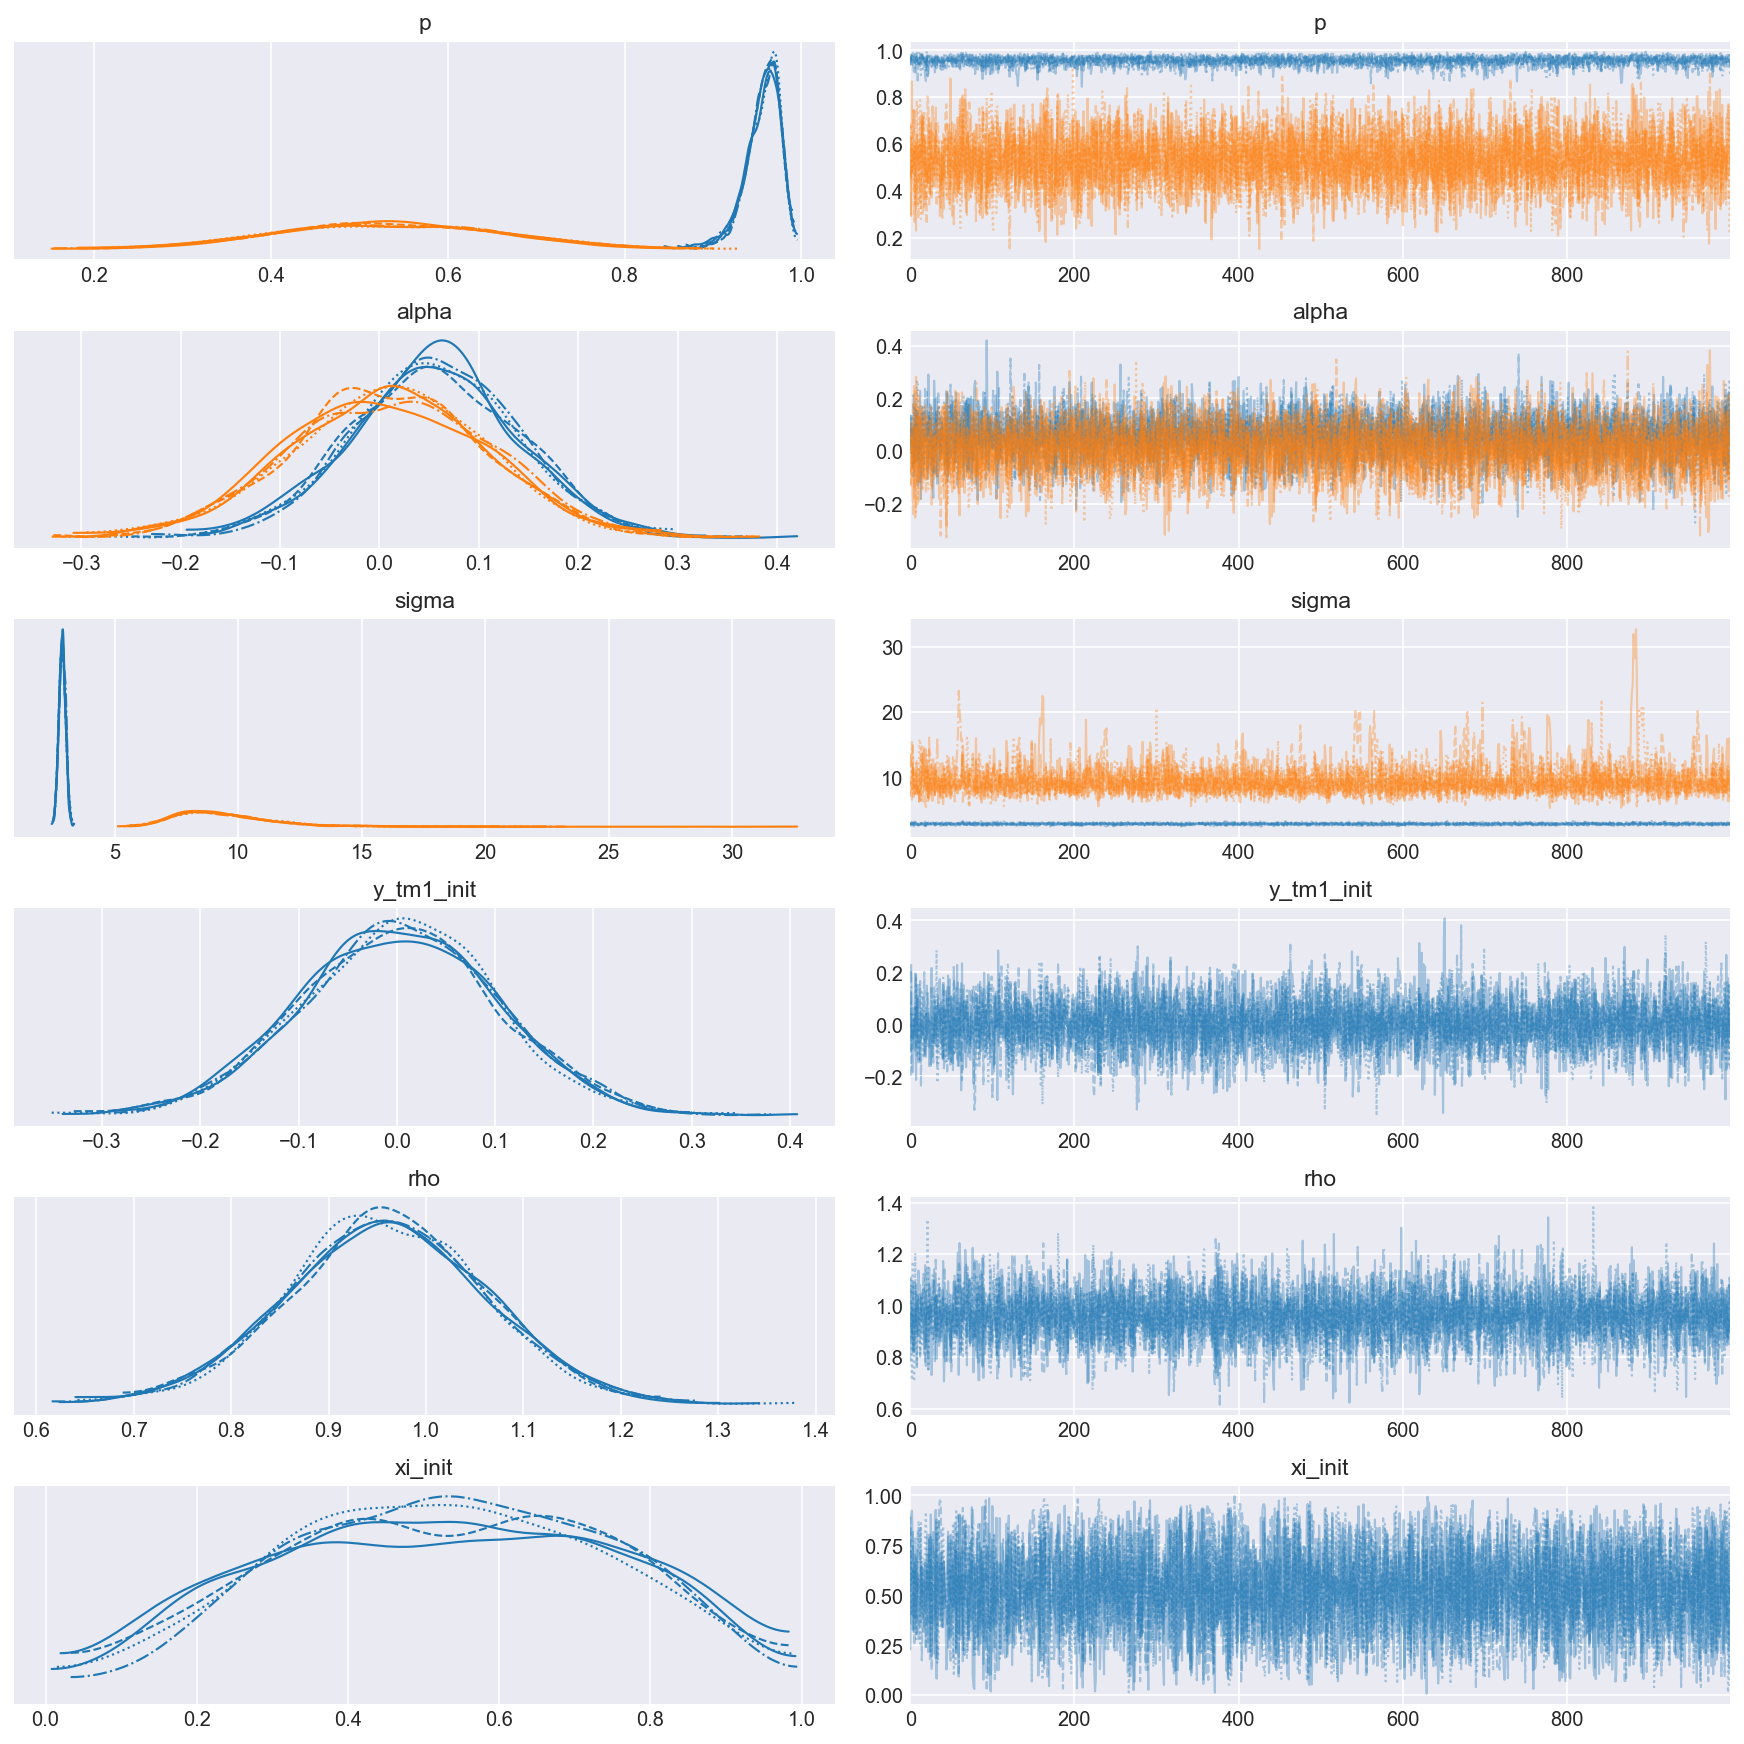

In [18]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept', 'reach_max_depth']
sample_stats = {k:v.T for k, v in zip(sample_stats_name, sampler_stats)}

var_name = ['p', 'alpha', 'sigma', 'y_tm1_init', 'rho', 'xi_init']
posterior = {k:np.swapaxes(v, 1, 0)
             for k, v in zip(var_name, nuts_samples)}

nuts_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)
az.plot_trace(nuts_trace, compact=True);

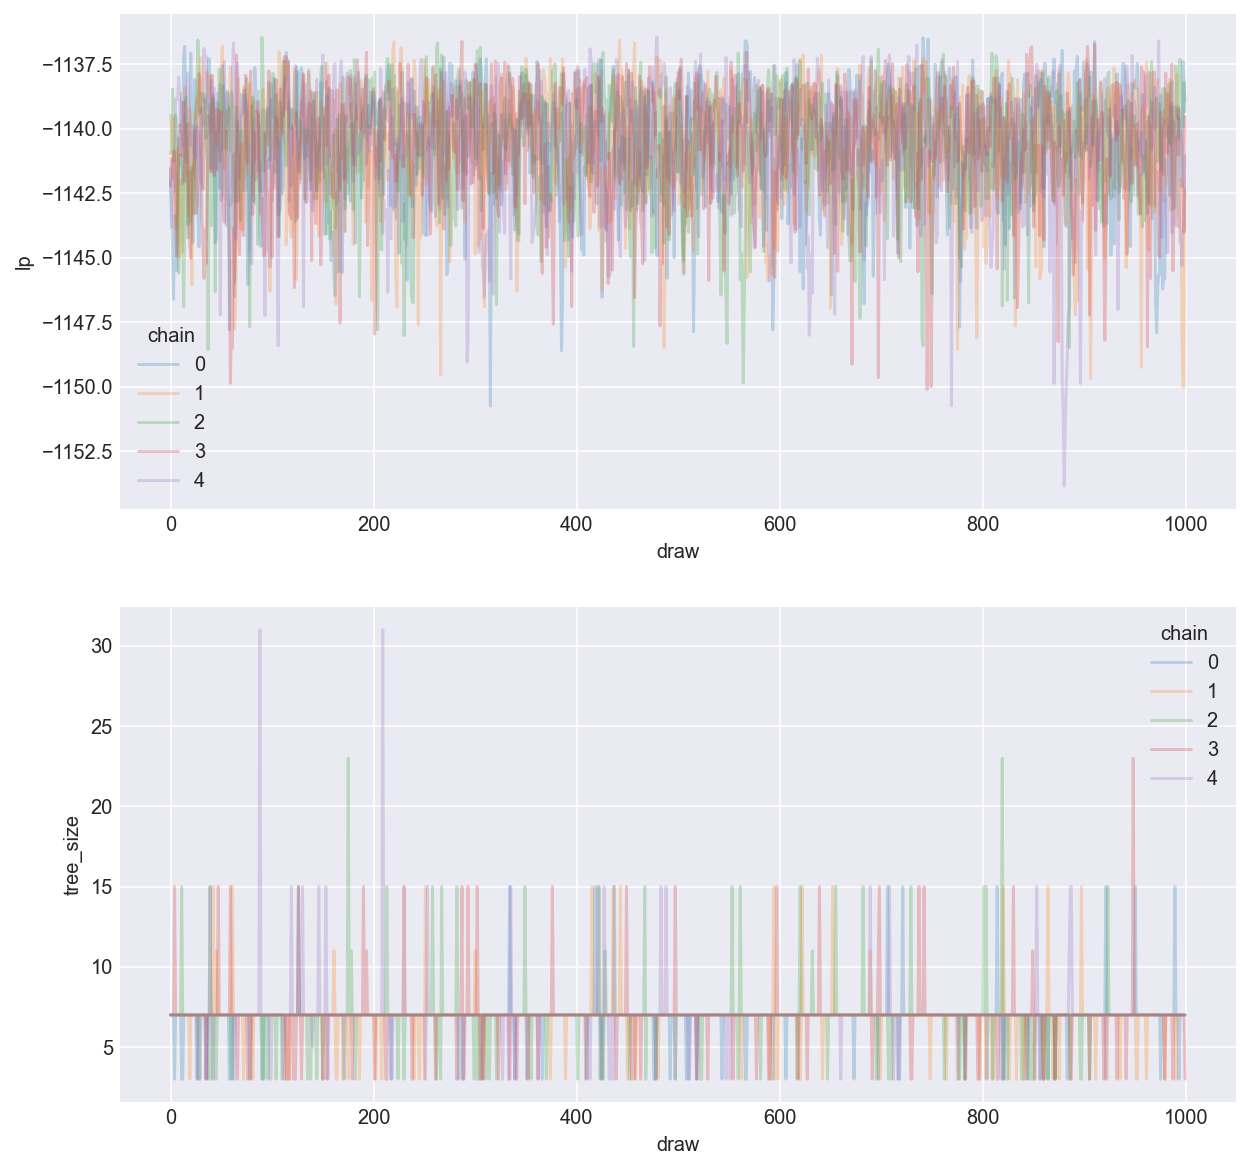

In [19]:
_, ax = plt.subplots(2, 1, figsize=(10, 10))
nuts_trace.sample_stats.get('lp').plot.line(hue='chain', alpha=.25, ax=ax[0]);
nuts_trace.sample_stats.get('tree_size').plot.line(hue='chain', alpha=.25, ax=ax[1]);

In [38]:
#@title Sample with CheeS
unnest = tfp.experimental.unnest

def gen_chess_sample_fn(target_log_prob_fn, bijector, draws, tune):

  @jax.jit
  def run_inference_chess(init_state, seed, step_size=.1, max_energy_diff=1000):
    num_adaptation_steps = int(tune * 0.8)

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=jnp.asarray(step_size, dtype=dtype),
        num_leapfrog_steps=10,
    )
    kernel = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(
        kernel,
        num_adaptation_steps=num_adaptation_steps,
        adaptation_rate=jnp.asarray(.025, dtype=dtype))
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        kernel, num_adaptation_steps=num_adaptation_steps)
    kernel = tfp.mcmc.TransformedTransitionKernel(
        kernel, bijector)

    def trace_fn(_, pkr):
      energy_diff = pkr.inner_results.inner_results.inner_results.log_accept_ratio
      has_divergence = jnp.abs(energy_diff) > max_energy_diff
      return (
          unnest.get_innermost(pkr, 'target_log_prob'),
          unnest.get_innermost(pkr, 'num_leapfrog_steps'),
          has_divergence,
          energy_diff,
          pkr.inner_results.inner_results.inner_results.log_accept_ratio,
          pkr.inner_results.inner_results.max_trajectory_length,
          unnest.get_innermost(pkr, 'step_size'),
      )
    # The chain will be stepped for num_results + num_burnin_steps, adapting for
    # the first num_adaptation_steps.
    return tfp.mcmc.sample_chain(
            num_results=draws,
            num_burnin_steps=tune,
            current_state=init_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=seed)
    
  return run_inference_chess

In [39]:
nchains = 10

init_state = jax.tree_map(lambda x: jnp.repeat(x, nchains, axis=0), init_state_)
# init_state_ = prior.sample(nchains, seed=jax.random.PRNGKey(10))
# seed, *init_seed = jax.random.split(jax.random.PRNGKey(16234), len(bijector)+1)
# init_state = jax.tree_multimap(lambda bij, x, rng: bij.forward(
#     tfd.Uniform(jnp.array(-1., dtype=x.dtype), 1.).sample(
#         bij.inverse(x).shape, seed=rng)),
#     bijector, list(init_state_), init_seed)

In [40]:
%%time
run_inference = gen_chess_sample_fn(target_log_prob_fn, bijector, 1000, 500)

seed, inference_seed = jax.random.split(jax.random.PRNGKey(16234), 2)
mcmc_samples, sampler_stats = run_inference(init_state, inference_seed)
_ = mcmc_samples[0].block_until_ready()

CPU times: user 2min 29s, sys: 2.32 s, total: 2min 31s
Wall time: 2min 21s


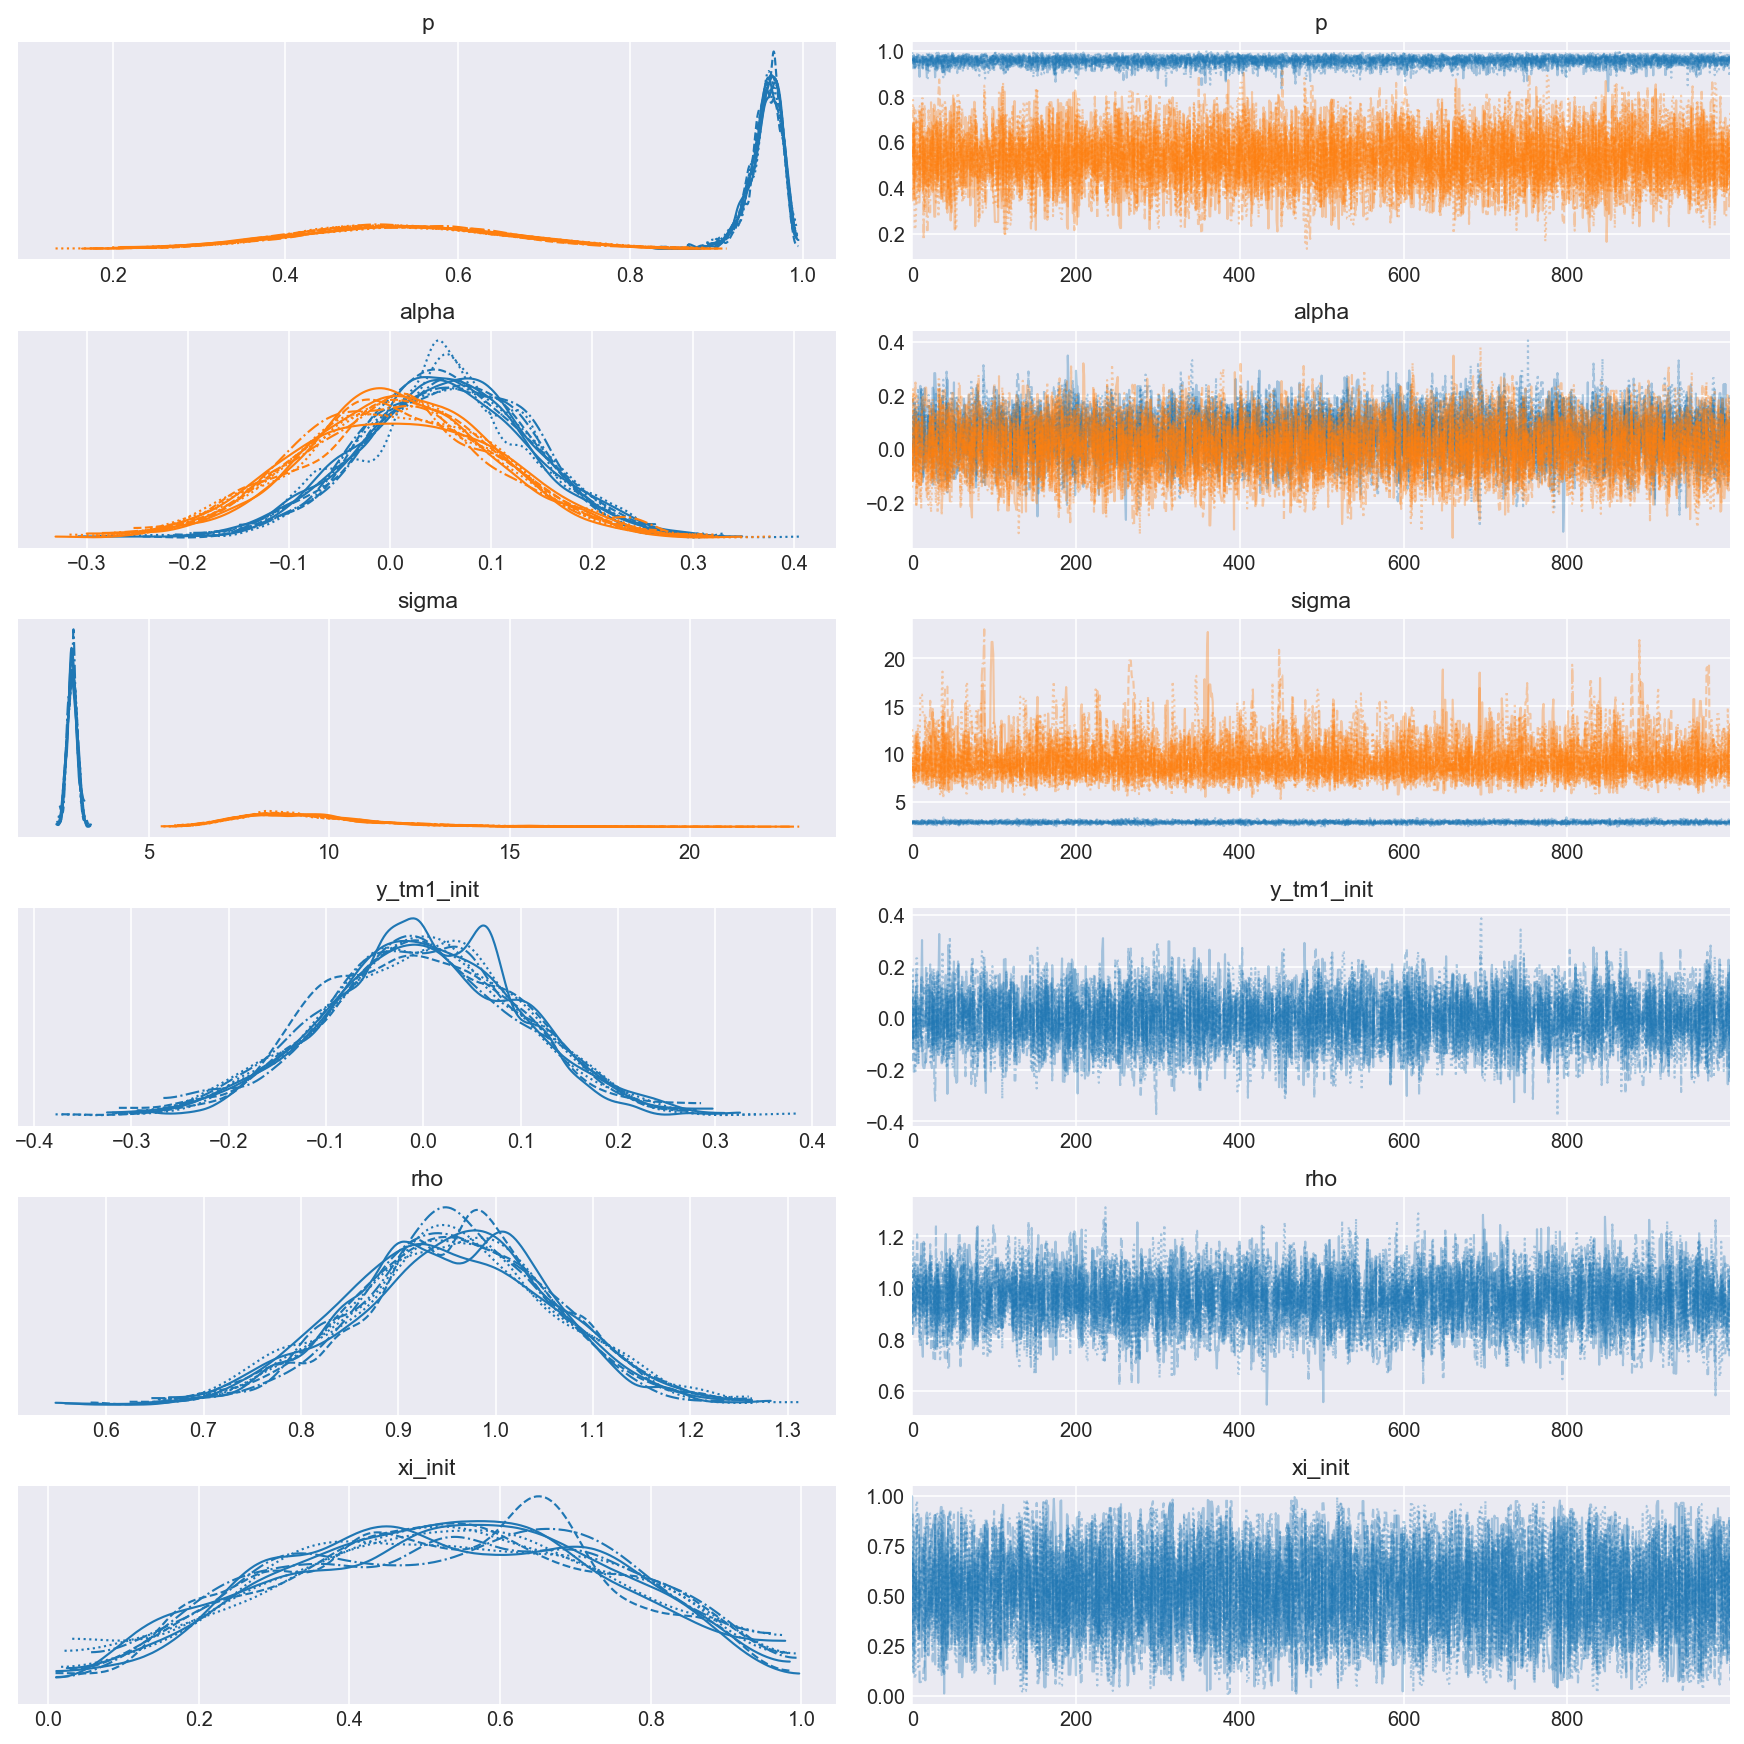

In [41]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept', 'max_tree_size', 'step_size']
sample_stats = {k:v.T for k, v in zip(sample_stats_name, sampler_stats)}

var_name = ['p', 'alpha', 'sigma', 'y_tm1_init', 'rho', 'xi_init']
posterior = {k:np.swapaxes(v, 1, 0)
             for k, v in zip(var_name, mcmc_samples)}

chess_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)
az.plot_trace(chess_trace, compact=True);

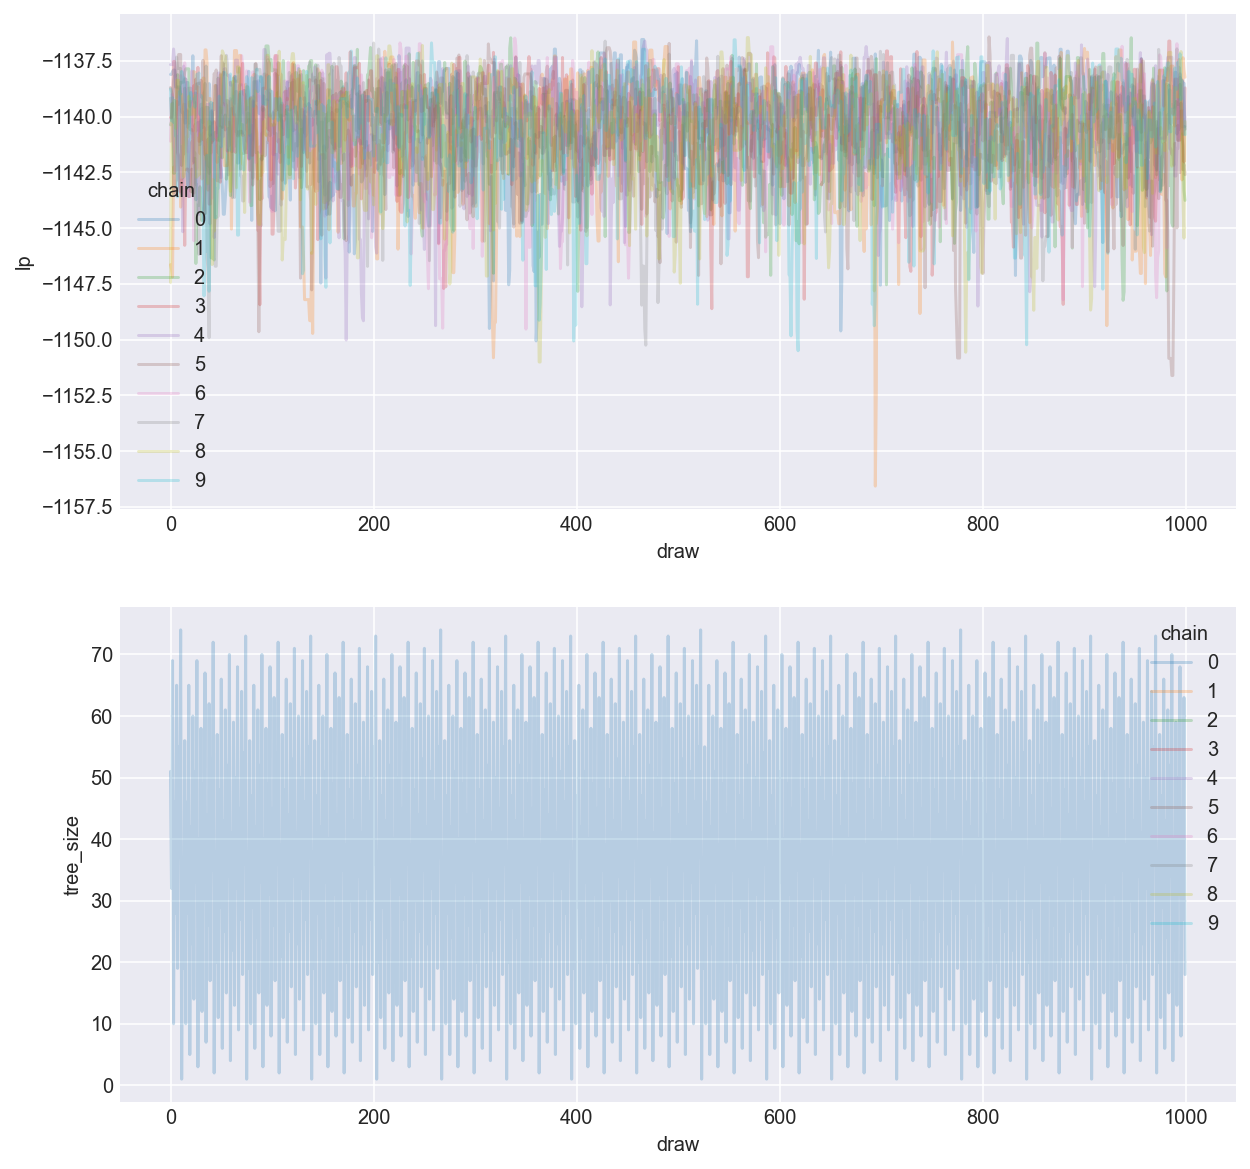

In [42]:
_, ax = plt.subplots(2, 1, figsize=(10, 10))
chess_trace.sample_stats.get('lp').plot.line(hue='chain', alpha=.25, ax=ax[0]);
chess_trace.sample_stats.get('tree_size').plot.line(hue='chain', alpha=.25, ax=ax[1]);

In [43]:
df = az.summary(nuts_trace, var_names=['alpha', 'rho', 'p', 'sigma'])
df.round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0]  0.06  0.08   -0.10     0.22       0.00     0.00    8525.0  3541.0   
alpha[1]  0.01  0.10   -0.18     0.19       0.00     0.00    9069.0  1873.0   
rho       0.96  0.10    0.76     1.15       0.00     0.00    7876.0  7876.0   
p[0]      0.96  0.02    0.92     0.99       0.00     0.00    3982.0  3982.0   
p[1]      0.53  0.12    0.32     0.77       0.00     0.00    6950.0  6511.0   
sigma[0]  2.87  0.14    2.63     3.14       0.00     0.00    6119.0  6119.0   
sigma[1]  9.50  2.24    5.95    13.13       0.05     0.04    1724.0  1263.0   

          ess_bulk  ess_tail  r_hat  
alpha[0]    8588.0    3620.0    1.0  
alpha[1]    9065.0    3511.0    1.0  
rho         7890.0    3856.0    1.0  
p[0]        3902.0    3007.0    1.0  
p[1]        6926.0    3619.0    1.0  
sigma[0]    6112.0    3865.0    1.0  
sigma[1]    3284.0    1796.0    1.0

In [44]:
df = az.summary(chess_trace, var_names=['alpha', 'rho', 'p', 'sigma'])
df.round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0]  0.06  0.08   -0.10     0.21       0.00     0.00    6412.0  4379.0   
alpha[1]  0.01  0.10   -0.18     0.19       0.00     0.00    7155.0  3143.0   
rho       0.96  0.10    0.76     1.14       0.00     0.00    4876.0  4876.0   
p[0]      0.96  0.02    0.92     0.99       0.00     0.00    6517.0  6483.0   
p[1]      0.53  0.12    0.30     0.75       0.00     0.00    6983.0  6798.0   
sigma[0]  2.87  0.14    2.62     3.13       0.00     0.00    6375.0  6340.0   
sigma[1]  9.43  1.98    6.20    13.03       0.03     0.02    4611.0  3861.0   

          ess_bulk  ess_tail  r_hat  
alpha[0]    6423.0    4911.0    1.0  
alpha[1]    7168.0    4673.0    1.0  
rho         4908.0    3793.0    1.0  
p[0]        5956.0    4631.0    1.0  
p[1]        6976.0    4860.0    1.0  
sigma[0]    6388.0    5102.0    1.0  
sigma[1]    7140.0    3473.0    1.0

Compare with Stan fit:
```
## Inference for Stan model: regime_switching_model.
## 4 chains, each with iter=1000; warmup=500; thin=1; 
## post-warmup draws per chain=500, total post-warmup draws=2000.
## 
##          mean se_mean   sd  2.5%   25%  50%   75% 97.5% n_eff Rhat
## alpha[1] 0.06    0.00 0.08 -0.10  0.00 0.06  0.11  0.21  2000    1
## alpha[2] 0.01    0.00 0.10 -0.20 -0.06 0.01  0.07  0.21  2000    1
## rho      0.96    0.00 0.10  0.76  0.89 0.96  1.03  1.16  2000    1
## p[1]     0.96    0.00 0.02  0.92  0.95 0.96  0.97  0.99  2000    1
## p[2]     0.54    0.00 0.12  0.31  0.46 0.55  0.63  0.77  2000    1
## sigma[1] 2.85    0.00 0.13  2.59  2.77 2.85  2.94  3.10  2000    1
## sigma[2] 9.69    0.06 2.26  6.56  8.15 9.24 10.76 15.31  1672    1
## 
## Samples were drawn using NUTS(diag_e) at Wed Feb 28 11:22:52 2018.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).
```

In [45]:
posterior_val = [
  np.reshape(v, [v.shape[0]*v.shape[1], -1]).squeeze()
  for v in nuts_samples]
print([v.shape for v in posterior_val])
_, xi_post = build_time_series(*posterior_val)

[(5000, 2), (5000, 2), (5000, 2), (5000,), (5000,), (5000,)]


In [46]:
xilo, xihi = np.percentile(xi_post, [2.5, 97.5], axis=0)
googl = (googl.assign(xipost = np.mean(xi_post, axis=0))
              .assign(xilower = xilo)
              .assign(xihigher = xihi)
        )

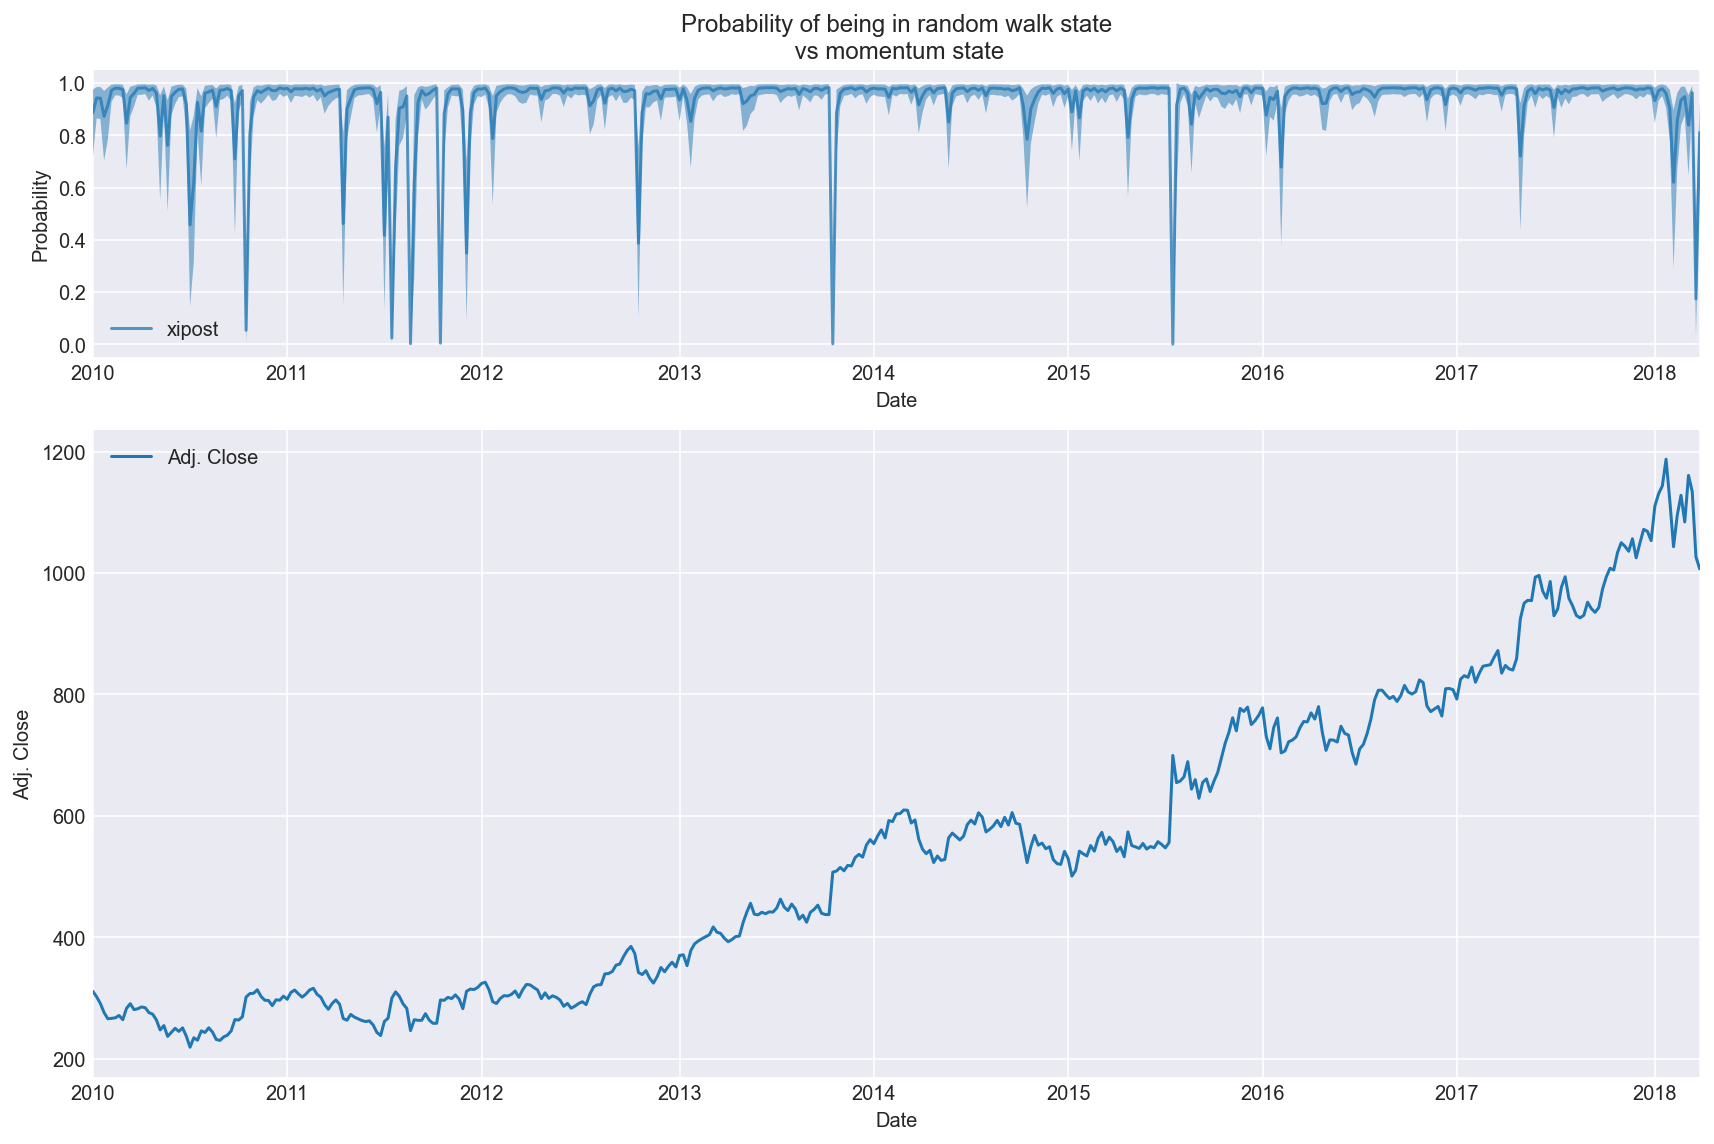

In [47]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), fig=fig)
ax2 = plt.subplot2grid((3, 1), (1, 0), fig=fig, rowspan=2)

googl.plot(y='xipost', alpha=.75, ax=ax1,
           title="Probability of being in random walk state\n vs momentum state")
ax1.fill_between(googl.index, googl.xilower, googl.xihigher, alpha=.5)
ax1.set_ylabel('Probability')
googl.plot(y='Adj. Close', ax=ax2)
ax2.set_ylabel('Adj. Close')
plt.tight_layout();